In [25]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer
import re
import contractions


In [26]:
# Read the CSV file
x_train = pd.read_csv('../data/x_train.csv')
x_valid = pd.read_csv('../data/x_valid.csv')
y_train = pd.read_csv('../data/y_train.csv')
y_valid = pd.read_csv('../data/y_valid.csv')
y_train['Target'] = y_train['Target'].replace(4, 1)
y_valid['Target'] = y_valid['Target'].replace(4, 1)


In [27]:
x_train = x_train.drop(['ID', 'Date', 'flag', 'User'], axis = 'columns')
x_train['Text'] = x_train['Text'].replace(r"@\w+", "", regex=True)
x_train['Text'] = x_train['Text'].apply(lambda x: contractions.fix(x))
x_train['Text'] = x_train['Text'].apply(lambda x: re.sub(r'[^\w\s]', '', x))
x_train['Text'] = x_train['Text'].apply(lambda x: re.sub(r'http\S+', '', x))
x_train['Text'] = x_train['Text'].str.lower()
x_train['Text'] = x_train["Text"].apply(lambda x: " ".join([w for w in x.split() if len(w)>=2]))
tokenized_tweet = x_train['Text'].apply(lambda x: x.split())
wnl = WordNetLemmatizer()

tokenized_tweet = tokenized_tweet.apply(lambda s: [wnl.lemmatize(word, pos='v') for word in s])
tokenized_tweet = tokenized_tweet.apply(lambda s: [wnl.lemmatize(word, pos='n') for word in s])
tokenized_tweet = tokenized_tweet.apply(lambda s: [wnl.lemmatize(word, pos='a') for word in s])
tokenized_tweet = tokenized_tweet.apply(lambda s: [wnl.lemmatize(word, pos='r') for word in s])
combined_sentences = [' '.join(tokens) for tokens in tokenized_tweet]


In [28]:
x_train['Text'] = combined_sentences

In [29]:
x_valid = x_valid.drop(['ID', 'Date', 'flag', 'User'], axis = 'columns')
x_valid['Text'] = x_valid['Text'].replace(r"@\w+", "", regex=True)
x_valid['Text'] = x_valid['Text'].apply(lambda x: contractions.fix(x))
x_valid['Text'] = x_valid['Text'].apply(lambda x: re.sub(r'[^\w\s]', '', x))
x_valid['Text'] = x_valid['Text'].apply(lambda x: re.sub(r'http\S+', '', x))
x_valid['Text'] = x_valid['Text'].str.lower()
x_valid['Text'] = x_valid["Text"].apply(lambda x: " ".join([w for w in x.split() if len(w)>=2]))
tokenized_tweet = x_valid['Text'].apply(lambda x: x.split())
wnl = WordNetLemmatizer()

tokenized_tweet = tokenized_tweet.apply(lambda s: [wnl.lemmatize(word, pos='v') for word in s])
tokenized_tweet = tokenized_tweet.apply(lambda s: [wnl.lemmatize(word, pos='n') for word in s])
tokenized_tweet = tokenized_tweet.apply(lambda s: [wnl.lemmatize(word, pos='a') for word in s])
tokenized_tweet = tokenized_tweet.apply(lambda s: [wnl.lemmatize(word, pos='r') for word in s])
combined_sentences = [' '.join(tokens) for tokens in tokenized_tweet]
x_valid['Text'] = combined_sentences

In [30]:
x_valid

,Text
0,tierd and it be school tomorrow last week atleast
1,twitter get bore bore everydayno star want rep...
2,be watch guy ripley right nowhahahilarious
3,that be the way indoor stadium toilet be
4,it must be all that bike rid
...,...
220196,wantd 2b comedian when lil boy memrize commerc...
220197,omg cannot believe jay leno be go off the air
220198,do not know my day be all mess up since get ou...
220199,so be guessin mean midnight pacific time


In [31]:
training_sentences = x_train['Text'].tolist()
testing_sentences = x_valid['Text'].tolist()


In [32]:
training_labels = y_train['Target'].tolist()
testing_labels = y_valid['Target'].tolist()


In [33]:
vocab_size = 100000
oov_tok = "<OOV>"
max_length = 120

In [36]:
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(training_sentences)

word_index = tokenizer.word_index

training_sequences = tokenizer.texts_to_sequences(training_sentences)
training_padded = pad_sequences(training_sequences,
                                maxlen = max_length, 
                                padding = 'post',
                                truncating = 'post')

testing_sequences = tokenizer.texts_to_sequences(testing_sentences)
testing_padded = pad_sequences(testing_sequences, 
                                maxlen = max_length,
                                padding = 'post',
                                truncating = 'post')


In [37]:
training_padded = np.array(training_padded)
training_labels = np.array(training_labels)
testing_padded = np.array(testing_padded)
testing_labels = np.array(testing_labels)

In [38]:
training_labels.shape, training_padded.shape, testing_labels.shape, testing_padded.shape

((513801,), (513801, 120), (220201,), (220201, 120))

In [39]:
embedding_dim = 16


In [40]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(24, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])



In [41]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_1      │ ?                      │   0 (unbuilt) │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [42]:
num_epochs = 2

In [43]:
history = model.fit(training_padded, 
                    training_labels, 
                    epochs=num_epochs, 
                    validation_data=(testing_padded, 
                                     testing_labels), 
                    verbose=2)

Epoch 1/2
16057/16057 - 412s - 26ms/step - accuracy: 0.8132 - loss: 0.4245 - val_accuracy: 0.8266 - val_loss: 0.3912
Epoch 2/2
16057/16057 - 327s - 20ms/step - accuracy: 0.8380 - loss: 0.3747 - val_accuracy: 0.8416 - val_loss: 0.3650


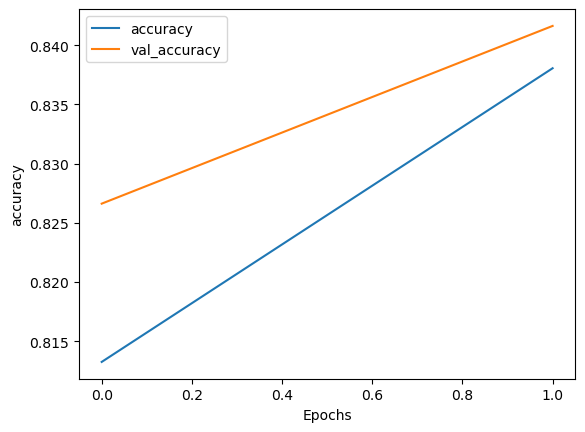

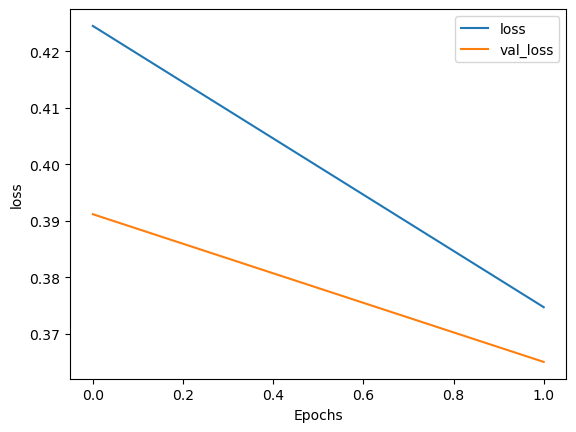

In [44]:
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()
  
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")